In [1]:
# import zipfile as zf
# files = zf.ZipFile("RSICD_images.zip", 'r')
# files.extractall('RSICD_image')
# files.close()

In [2]:
# Install necessary libraries
#!pip install transformers datasets accelerate torch torchvision Pillow nltk matplotlib scikit-image pycocotools

# Note: For full CIDEr implementation, you might need to install pycocoevalcap manually
# For instance, by cloning its GitHub repo and installing:
# !git clone https://github.com/tylin/coco-caption.git
# !cd coco-caption/pycocoevalcap && pip install .
#!pip install nltk


In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import json
import os
from transformers import ViTImageProcessor, ViTModel, AutoTokenizer, GPT2LMHeadModel, get_scheduler
from tqdm.auto import tqdm # Import tqdm for progress bars
import evaluate # Hugging Face evaluate library
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from collections import defaultdict

# Download necessary NLTK data for evaluation metrics
try:
    nltk.data.find('tokenizers/punkt')
except:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/wordnet')
except:
    nltk.download('wordnet')

# For COCO-eval-style metrics (BLEU, METEOR, ROUGE_L, CIDEr)
# We will use the `evaluate` library for most, and conceptually outline CIDEr.
from evaluate import load

2025-07-22 12:26:48.297003: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-22 12:26:48.304004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753151208.312303   29294 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753151208.314964   29294 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753151208.321781   29294 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
class RSICDDataset(Dataset):
    def __init__(self, json_path, img_dir, image_processor, tokenizer, max_seq_length=50):
        """
        Args:
            json_path (str): Path to the dataset_rsicd.json file.
            img_dir (str): Directory containing the images.
            image_processor: Hugging Face ViTImageProcessor.
            tokenizer: Hugging Face GPT2Tokenizer.
            max_seq_length (int): Maximum sequence length for captions.
        """
        with open(json_path, 'r') as f:
            self.data = json.load(f)['images']
        self.img_dir = img_dir
        self.image_processor = image_processor
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

        # Create mappings for split
        self.train_data = [item for item in self.data if item['split'] == 'train']
        self.val_data = [item for item in self.data if item['split'] == 'val']
        self.test_data = [item for item in self.data if item['split'] == 'test']

    def __len__(self):
        return len(self.current_data)

    def __getitem__(self, idx):
        item = self.current_data[idx]
        img_filename = item['filename']
        img_path = os.path.join(self.img_dir, img_filename)

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return dummy data or skip, for robustness
            return self.__getitem__((idx + 1) % len(self.current_data)) # Try next item


        # Process image
        pixel_values = self.image_processor(images=image, return_tensors="pt").pixel_values.squeeze()

        # Select a random caption for training, or all for evaluation
        caption_info = item['sentences']
        if self.mode == 'train':
            caption = caption_info[torch.randint(0, len(caption_info), (1,)).item()]['raw']
        else:
            caption = [s['raw'] for s in caption_info] # Keep all raw captions for evaluation

        if self.mode == 'train':
            # Tokenize caption and prepare for GPT-2
            # Add bos_token and eos_token for sequence beginning and end
            tokenized_caption = self.tokenizer(
                caption,
                max_length=self.max_seq_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            labels = tokenized_caption.input_ids.squeeze()
            attention_mask = tokenized_caption.attention_mask.squeeze()
            return pixel_values, labels, attention_mask
        else:
            # For evaluation, return pixel values, the original image filename, and all raw captions
            return pixel_values, img_filename, caption

    def set_mode(self, mode):
        if mode == 'train':
            self.current_data = self.train_data
        elif mode == 'val':
            self.current_data = self.val_data
        elif mode == 'test':
            self.current_data = self.test_data
        else:
            raise ValueError("Mode must be 'train', 'val', or 'test'")
        self.mode = mode


# Initialize image processor and tokenizer
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Add padding token if not already present
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Ensure bos_token and eos_token are set for GPT-2 if not already.
if tokenizer.bos_token is None:
    tokenizer.bos_token = tokenizer.cls_token if tokenizer.cls_token else tokenizer.mask_token
    if tokenizer.bos_token is None:
        tokenizer.add_special_tokens({'bos_token': '<s>'})
if tokenizer.eos_token is None:
    tokenizer.add_special_tokens({'eos_token': '</s>'})

# Define paths (adjust as per your setup)
json_path = 'dataset_rsicd.json'

# Assuming images are in a directory named 'RSICD_images' relative to your notebook
# You'll need to create this directory and place your images inside.
img_dir = "/home/shay/Desktop/UNSW/9444/project/39/RSICD_optimal-master/RSICD_optimal-master/RSICD_images/RSICD_images" # Placeholder: Make sure this directory exists and contains the images

# Create dataset instances
train_dataset = RSICDDataset(json_path, img_dir, image_processor, tokenizer)
val_dataset = RSICDDataset(json_path, img_dir, image_processor, tokenizer)
test_dataset = RSICDDataset(json_path, img_dir, image_processor, tokenizer)

train_dataset.set_mode('train')
val_dataset.set_mode('val')
test_dataset.set_mode('test')

# Create DataLoaders
batch_size = 42 # Adjust batch size based on your GPU memory
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class ViTGPT2Model(torch.nn.Module):
    def __init__(self, vit_model_name='google/vit-base-patch16-224', gpt2_model_name='gpt2'):
        super().__init__()
        self.vit = ViTModel.from_pretrained(vit_model_name)
        self.gpt2 = GPT2LMHeadModel.from_pretrained(gpt2_model_name)

        # Resize token embeddings of GPT-2 if a new pad_token was added
        if tokenizer.pad_token_id is not None and len(tokenizer) > self.gpt2.config.vocab_size:
             self.gpt2.resize_token_embeddings(len(tokenizer))

        # Project ViT's CLS token embedding to GPT-2's hidden size
        self.vit_to_gpt2_projection = torch.nn.Linear(self.vit.config.hidden_size, self.gpt2.config.hidden_size)

    def forward(self, pixel_values, labels=None, attention_mask=None):
        # Get image features from ViT
        vit_outputs = self.vit(pixel_values=pixel_values)
        # We'll use the [CLS] token output as the image representation
        image_features = vit_outputs.last_hidden_state[:, 0, :] # Shape: (batch_size, hidden_size)

        # Project ViT features to GPT-2's embedding space
        projected_image_features = self.vit_to_gpt2_projection(image_features) # Shape: (batch_size, gpt2_hidden_size)

        batch_size = labels.shape[0]
        # Get the standard embeddings for the labels
        token_embeddings = self.gpt2.transformer.wte(labels)

        # Create a combined embedding: projected_image_features + token_embeddings (excluding the first token's original embedding)
        # This assumes the `labels` for training will always start with tokenizer.bos_token_id.
        combined_embeddings = torch.cat((projected_image_features.unsqueeze(1), token_embeddings[:, 1:, :]), dim=1)

        # Create an attention mask that accounts for the prepended image feature
        attention_mask_image = torch.cat((torch.ones(batch_size, 1, device=attention_mask.device), attention_mask[:, 1:]), dim=1)

        # Pass the combined embeddings to GPT-2
        gpt2_outputs = self.gpt2(
            inputs_embeds=combined_embeddings,
            attention_mask=attention_mask_image,
            labels=labels # labels are for calculating loss
        )

        return gpt2_outputs.loss, gpt2_outputs.logits

    @torch.no_grad()
    def generate_caption(self, pixel_values, max_length=50, num_beams=5, temperature=1.0, top_k=50, top_p=0.95, do_sample=False):
        # Get image features from ViT
        vit_outputs = self.vit(pixel_values=pixel_values)
        image_features = vit_outputs.last_hidden_state[:, 0, :]
        projected_image_features = self.vit_to_gpt2_projection(image_features)

        # Initialize input_ids with BOS token for generation
        input_ids = torch.full((pixel_values.shape[0], 1), tokenizer.bos_token_id, dtype=torch.long, device=pixel_values.device)

        output_ids = self.gpt2.generate(
            input_ids=input_ids,
            max_length=max_length,
            num_beams=num_beams,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=do_sample,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

        return [tokenizer.decode(g, skip_special_tokens=True) for g in output_ids]

In [6]:
# ⭐ GPU READY CODE:
# This line checks if a CUDA-enabled GPU is available and sets the device accordingly.
# For this to print "Using device: cuda", you need to have:
# 1. An NVIDIA GPU.
# 2. NVIDIA drivers installed.
# 3. CUDA Toolkit installed (compatible with your PyTorch version).
# 4. PyTorch installed with CUDA support (e.g., `pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118`).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ViTGPT2Model().to(device) # ⭐ GPU READY: Moves the entire model to the selected device

# Optional: Freeze ViT parameters to train only the GPT-2 decoder and the projection layer.
# This can save memory and speed up training if ViT features are already good.
# for param in model.vit.parameters():
#     param.requires_grad = False

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5) # Adjust learning rate

num_epochs = 15 # Adjust number of epochs
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# ⭐ TQDM PROGRESS BAR FOR TRAINING:
progress_bar = tqdm(range(num_training_steps), desc="Training Progress")

model.train()
for epoch in range(num_epochs):
    for batch_idx, (pixel_values, labels, attention_mask) in enumerate(train_dataloader):
        # ⭐ GPU READY: Move batch data to the selected device
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)
        attention_mask = attention_mask.to(device)

        loss, logits = model(pixel_values=pixel_values, labels=labels, attention_mask=attention_mask)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # ⭐ TQDM PROGRESS BAR UPDATE:
        progress_bar.update(1)
        progress_bar.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Optional: Save model checkpoint after each epoch
    # torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

Using device: cuda


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Training Progress:   0%|          | 0/3120 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
/tmp/ipykernel_29294/314690190.py:47: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  progress_bar.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


In [7]:
torch.cuda.empty_cache()

In [8]:
model.eval()

all_generated_captions = []
all_reference_captions = [] # This will be a list of lists: [[ref1_img1, ref2_img1], [ref1_img2, ref2_img2], ...]

print("Starting evaluation...")
# ⭐ TQDM PROGRESS BAR FOR EVALUATION:
eval_progress_bar = tqdm(val_dataloader, desc="Evaluating")

with torch.no_grad():
    for batch_idx, (pixel_values, img_filenames, reference_captions_for_one_image) in enumerate(eval_progress_bar):
        # ⭐ GPU READY: Move batch data to the selected device
        pixel_values = pixel_values.to(device)

        # Generate caption for a single image (batch size 1 in val_dataloader)
        generated_caption = model.generate_caption(
            pixel_values=pixel_values,
            max_length=50,
            num_beams=5, # Using beam search for better quality
            do_sample=False
        )[0] # Get the first (and only) generated caption from the batch

        all_generated_captions.append(generated_caption)
        # reference_captions_for_one_image is already `[['ref1', 'ref2', ...]]` from DataLoader for batch_size=1
        all_reference_captions.append(reference_captions_for_one_image[0])
 # Append the inner list of references

# Now, calculate metrics using the `evaluate` library
print("\nCalculating metrics...")

# Initialize evaluation metrics
bleu = load("bleu")
meteor = load("meteor")
rouge = load("rouge")

# BLEU 1-4
results_bleu1 = bleu.compute(predictions=all_generated_captions, references=all_reference_captions, max_order=1)
results_bleu2 = bleu.compute(predictions=all_generated_captions, references=all_reference_captions, max_order=2)
results_bleu3 = bleu.compute(predictions=all_generated_captions, references=all_reference_captions, max_order=3)
results_bleu4 = bleu.compute(predictions=all_generated_captions, references=all_reference_captions, max_order=4)

print(f"BLEU-1: {results_bleu1['bleu']:.4f}")
print(f"BLEU-2: {results_bleu2['bleu']:.4f}")
print(f"BLEU-3: {results_bleu3['bleu']:.4f}")
print(f"BLEU-4: {results_bleu4['bleu']:.4f}")

# METEOR
results_meteor = meteor.compute(predictions=all_generated_captions, references=all_reference_captions)
print(f"METEOR: {results_meteor['meteor']:.4f}")

# ROUGE-L
results_rouge = rouge.compute(predictions=all_generated_captions, references=all_reference_captions)
print(f"ROUGE-L: {results_rouge['rougeL']:.4f}")

# CIDEr (conceptual - requires pycocoevalcap setup)
# For a full CIDEr score, you would typically need to:
# 1. Convert `all_generated_captions` and `all_reference_captions` into the COCO format JSONs.
# 2. Use `pycocoevalcap.eval.COCOEvalCap` to compute the score.
# This requires `pycocoevalcap` to be installed and correctly set up,
# which often involves manually cloning and installing from source if not directly available via pip.
print("\nCIDEr: [Requires pycocoevalcap setup and specific JSON formatting for full computation]")

# Example of how you would structure data for COCO-eval (requires manual setup and pycocoevalcap):
# This part is commented out as it requires external setup.
# from pycocotools.coco import COCO
# from pycocoevalcap.eval import COCOEvalCap
#
# # Example of creating dummy image IDs and formatting for COCO-eval
# pred_data_cider = []
# gt_data_cider = {"images": [], "annotations": []}
# img_id_counter = 0
#
# for gen_cap, ref_caps_list in zip(all_generated_captions, all_reference_captions):
#     current_img_id = str(img_id_counter) # Use string IDs for COCO compatibility
#     pred_data_cider.append({"image_id": current_img_id, "caption": gen_cap})
#     gt_data_cider["images"].append({"id": current_img_id})
#     for ref_cap in ref_caps_list:
#         gt_data_cider["annotations"].append({"image_id": current_img_id, "caption": ref_cap, "id": len(gt_data_cider["annotations"])})
#     img_id_counter += 1
#
# # Save to temporary JSON files
# with open("predictions_cider.json", "w") as f:
#     json.dump(pred_data_cider, f)
# with open("ground_truth_cider.json", "w") as f:
#     json.dump(gt_data_cider, f)
#
# # Then, run COCOEvalCap
# try:
#     coco_gt = COCO("ground_truth_cider.json")
#     coco_res = coco_gt.loadRes("predictions_cider.json")
#     cocoEval = COCOEvalCap(coco_gt, coco_res)
#     cocoEval.params['image_id'] = coco_gt.getImgIds() # Ensure evaluation is over all image IDs
#     cocoEval.evaluate()
#     print(f"CIDEr: {cocoEval.eval['CIDEr']:.4f}")
# except Exception as e:
#     print(f"Could not compute CIDEr: {e}. Please ensure pycocoevalcap is correctly installed and configured.")

Starting evaluation...


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=


Calculating metrics...


[nltk_data] Downloading package wordnet to /home/shay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/shay/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/shay/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU-1: 0.7667
BLEU-2: 0.6102
BLEU-3: 0.4918
BLEU-4: 0.3932
METEOR: 0.5471
ROUGE-L: 0.5293

CIDEr: [Requires pycocoevalcap setup and specific JSON formatting for full computation]


In [9]:

torch.cuda.empty_cache()


The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


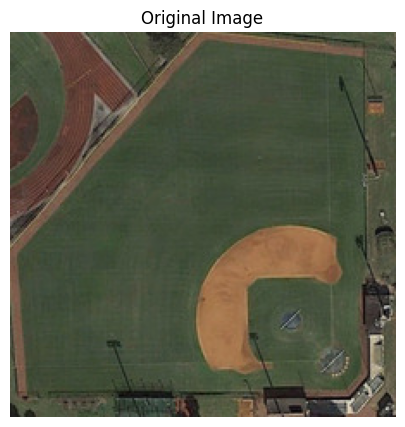

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Image: baseballfield_50.jpg
Generated Caption:  buildings and green trees are near a complicated viaduct .
Reference Captions:
  1. the land is a large baseball field .
  2. a lot of trees are planted around the baseball field .
  3. a lot of trees are planted around the baseball field .
  4. the land is a large baseball field .
  5. the land is a large baseball field .
--------------------------------------------------


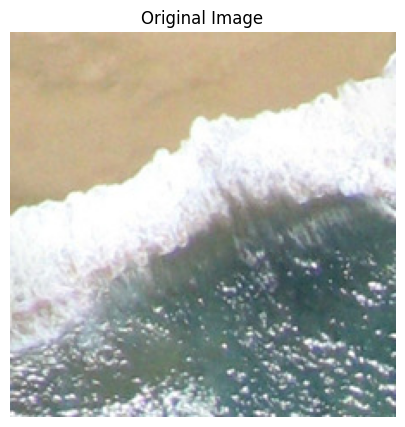

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Image: beach_52.jpg
Generated Caption:  buildings and green trees are near a complicated viaduct .
Reference Captions:
  1. the waves crash up on the beach .
  2. the waves crash up on the beach .
  3. the white wave between the reflective sea and the beach .
  4. this surge is patting the flat yellow beach .
  5. white waves are between green ocean and yellow beach .
--------------------------------------------------


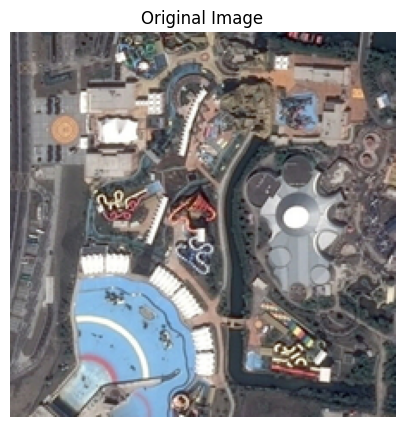

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Image: park_41.jpg
Generated Caption:  buildings and green trees are near a complicated viaduct .
Reference Captions:
  1. many tall buildings are built in the park .
  2. a large number of tall trees are planted in the park .
  3. a large number of tall trees are planted in the park .
  4. many tall buildings are built in the park .
  5. many tall buildings are built in the park .
--------------------------------------------------


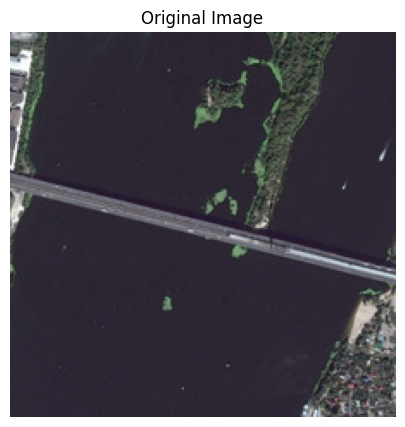

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Image: bridge_56.jpg
Generated Caption:  buildings and green trees are near a complicated viaduct .
Reference Captions:
  1. the bridge with a train in its center is across the gulf with a eyot .
  2. the river with a bridge across it has an irregular shaped island with trees in the middle .
  3. the bridge near a forest connects two cities .
  4. two prosperous city area is seperated by a long river with an island in it and is connected with a long bridge .
  5. an urban area and some buildings are in two sides of a river with a bridge over it and an island with many green trees in it .
--------------------------------------------------


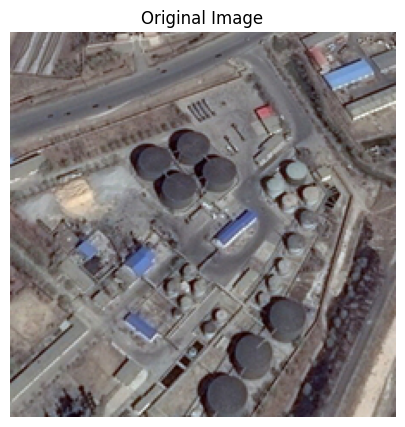

Image: storagetanks_352.jpg
Generated Caption:  buildings and green trees are near a complicated viaduct .
Reference Captions:
  1. there is a huge factory beside the road .
  2. many storage tanks are built in the factory .
  3. many storage tanks are built in the factory .
  4. there is a huge factory beside the road .
  5. there is a huge factory beside the road .
--------------------------------------------------


In [10]:
import matplotlib.pyplot as plt

def show_random_examples(dataset, model, num_examples=3):
    model.eval()
    indices = torch.randint(0, len(dataset), (num_examples,)).tolist()

    for idx in indices:
        pixel_values, img_filename, reference_captions = dataset.__getitem__(idx)
        original_image = Image.open(os.path.join(dataset.img_dir, img_filename)).convert("RGB")

        pixel_values_batch = pixel_values.unsqueeze(0).to(device) # Add batch dimension
        generated_caption = model.generate_caption(pixel_values_batch, num_beams=5, do_sample=False)[0]

        plt.figure(figsize=(10, 5))
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis('off')
        plt.show()

        print(f"Image: {img_filename}")
        print(f"Generated Caption: {generated_caption}")
        print("Reference Captions:")
        for i, ref in enumerate(reference_captions):
            print(f"  {i+1}. {ref}")
        print("-" * 50)

# Call this after training and evaluation to see examples
show_random_examples(test_dataset, model, num_examples=5) # Use test_dataset for unseen examples